# Классификация с помощью HOGDescriptor

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train_label = train[:, 0]
train_img = np.reshape(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.reshape(test, (test.shape[0], 28, 28))

train_img.shape, test_img.shape

((42000, 28, 28), (28000, 28, 28))

## Визуализируем исходные данные

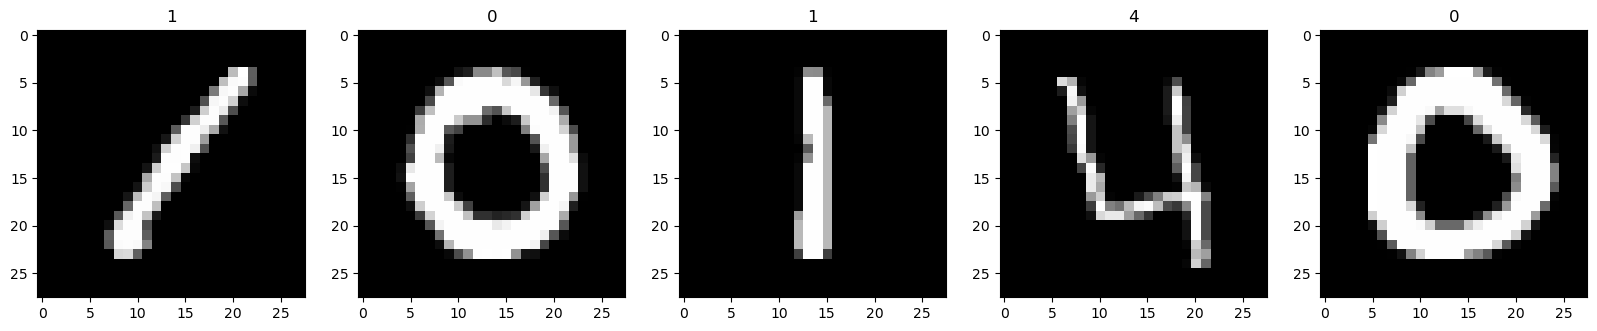

In [4]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(train_img[:5], 1):
    plt.subplot(150+i)
    plt.imshow(img, cmap='gray')
    plt.title(int(train_label[i-1]))

## Задаем параметры для вычисления дескриптора

In [5]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (7,7)
nbins = 8
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 1.8000000000000001e-01
gammaCorrection = 0
nlevels = 28

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

## Вычисляем дескрипторы для всех объектов

In [6]:
n = len(hog.compute(np.uint8(train_img[0])))
train_descr = np.zeros((train_img.shape[0], n))

for i in range(len(train_img)):
    train_descr[i] = hog.compute(np.uint8(train_img[i]))

## Разбиваем выборку на обучение и валидацию

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train_descr, train_label, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [8]:
centroids = np.zeros((10, train_descr.shape[1]), dtype=np.float32)

for i in range(10):
    centroids[i] = np.mean(X_train[y_train == i], axis=0)

## Находим ближайший центроид для валидации

In [9]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - X_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решения на валидационной выборке

In [10]:
accuracy_score(y_val, pred_val)

0.9169047619047619

In [11]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       816
         1.0       0.94      0.95      0.94       909
         2.0       0.93      0.93      0.93       846
         3.0       0.88      0.91      0.89       937
         4.0       0.94      0.93      0.94       839
         5.0       0.94      0.91      0.92       702
         6.0       0.96      0.96      0.96       785
         7.0       0.92      0.86      0.89       893
         8.0       0.83      0.86      0.85       835
         9.0       0.89      0.89      0.89       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



## Предсказания на тестовых данных

In [12]:
pred_test = np.zeros(len(test_img), np.uint8)

for i in range(len(test_img)):
    hog_ = hog.compute(np.uint8(test_img[i]))
    distances = np.linalg.norm(centroids - hog_, axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

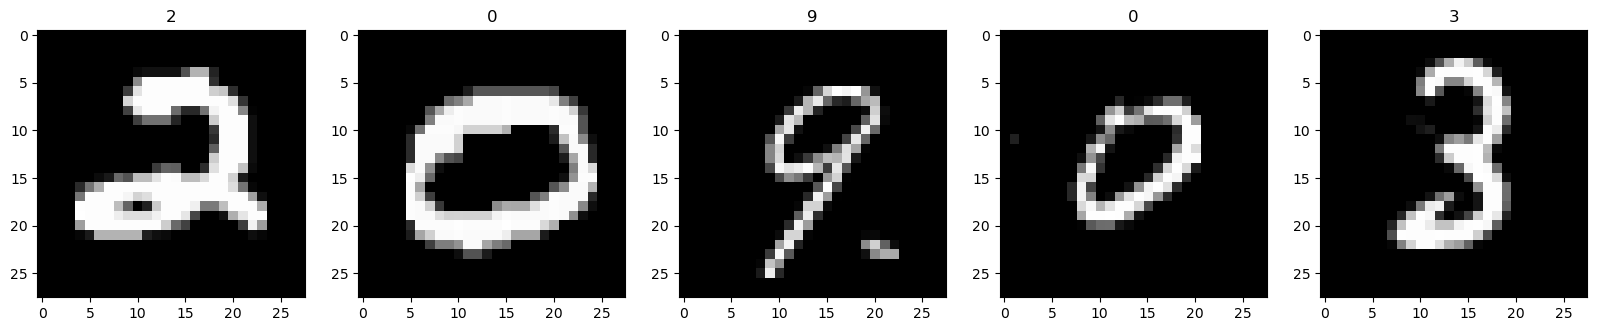

In [13]:
fig = plt.figure(figsize=(20, 10))

for i, img in enumerate(test_img[:5], 1):
    plt.subplot(150+i)
    plt.imshow(img, cmap='gray')
    plt.title(int(pred_test[i-1]))

## Готовим файл для отправки

In [14]:
with open('submit_final.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write(f'{i},{p}\n')

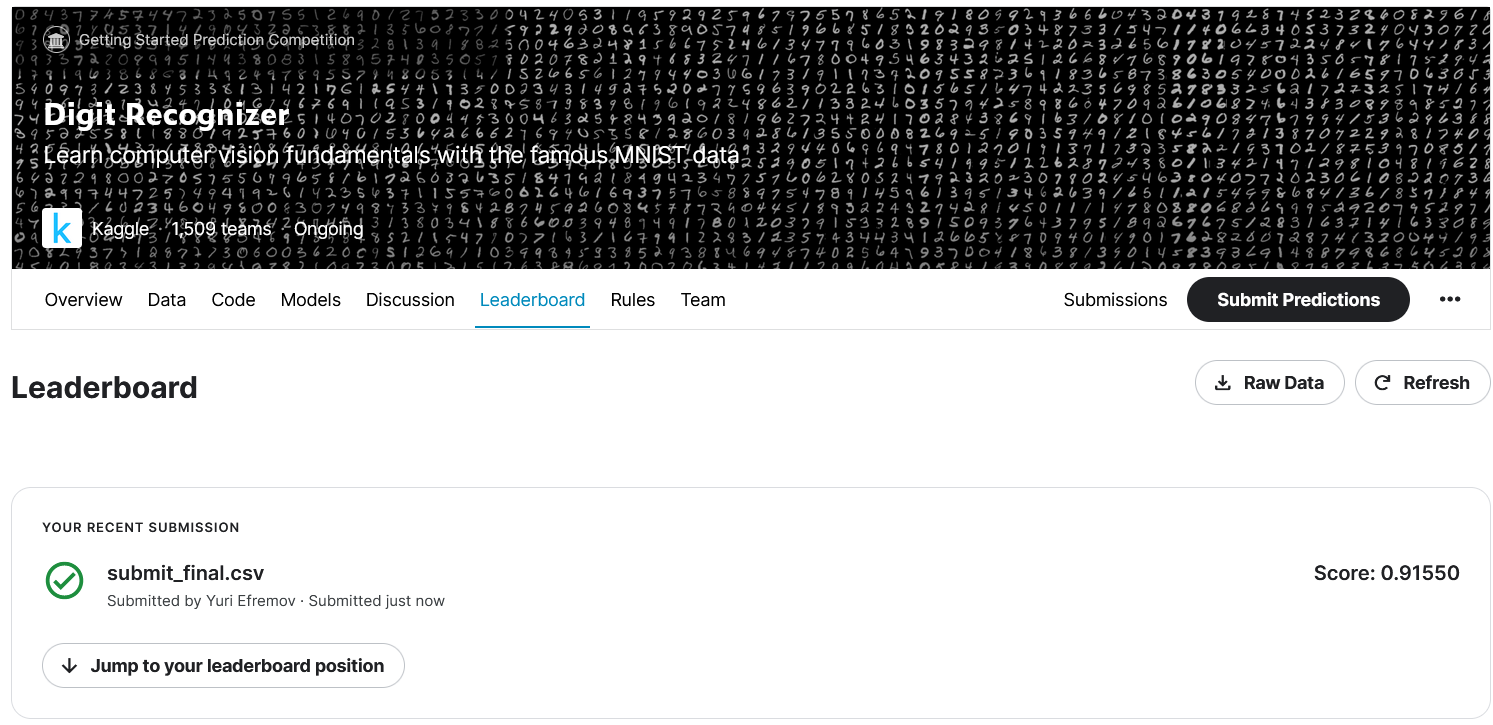